### Dataset

In [5]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [ ]:
path.ls()

# annotations: Infos wo das Tier im Bild ist (nicht was es ist (Wichtig für Lokalisiereung)
# images: Hier sind die Bilder der Haustiere

(#2) [Path('/home/lukelo-tshakulongo/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/lukelo-tshakulongo/.fastai/data/oxford-iiit-pet/images')]

In [8]:
(path/"images").ls

<bound method Path.ls of Path('/home/lukelo-tshakulongo/.fastai/data/oxford-iiit-pet/images')>

In [ ]:
# images/great_pyrenees_173.jpg  
# Wir wollen nur Rassennamen
fname = (path/"images").ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name) # Nur der Rassenname behalten

['english_cocker_spaniel']

In [ ]:
# Presizing
# Vergrößere alle Bilder zuerst auf einheitlich große Quadrate (z. B. 460×460)
    # → Das passiert in item_tfms=Resize(460)

# Alle Augmentierungen (Drehen, Zuschneiden etc.) werden dann in einem Schritt gemacht, direkt auf der GPU
    # → Das passiert in batch_tfms=aug_transforms(...)


pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Bild + Kategorie
    get_items=get_image_files,           # Bilder finden
    splitter=RandomSplitter(seed=42),    # Zufällige Aufteilung in Trainings-/Validierungsdaten
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),  # Regex für die Labels
    item_tfms=Resize(460),               # Bildgröße für Input (Die Bilder werden beim Laden auf 460px vergrößert oder verkleinert – einheitlich.)
    batch_tfms=aug_transforms(size=224, min_scale=0.75)  # Daten-Augmentierung (Zufallsveränderungen (Rotation, Zoom, etc.), damit das Modell robuster wird.)
)
dls = pets.dataloaders(path/"images")

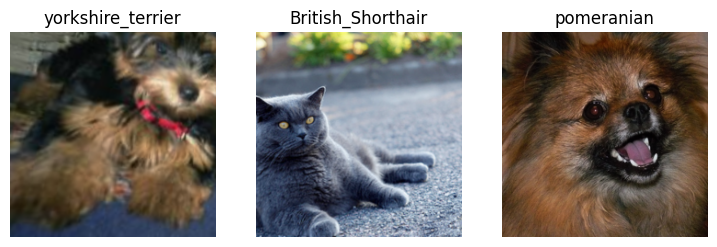

In [14]:
dls.show_batch(nrows=1, ncols=3)

### Training

In [18]:
# loss = „Wie schlecht ist das Modell aktuell?“
# error_rate = „Wie viele Vorhersagen waren falsch?“
# fastai wählt automatisch die passende Verlustfunktion
    # → Bei Bildern mit Kategorien = Cross Entropy Loss

learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.549191,0.334540,0.110961,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.514807,0.302156,0.102842,00:38
1,0.331479,0.255291,0.081191,00:42


### Modellinterpretation
#### Die Verwirrungsmatrix (Confusion Matrix)

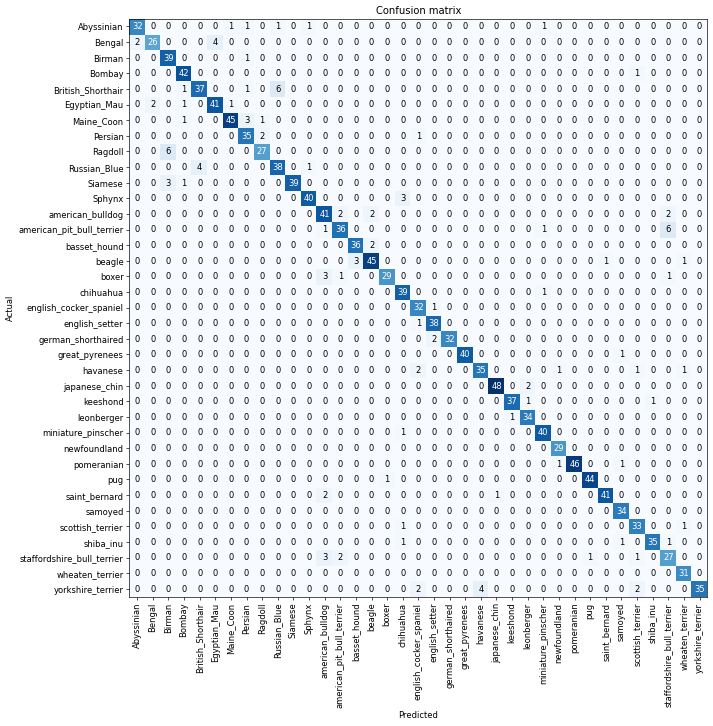

In [19]:
from fastai.interpret import *
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


Bei 37 Klassen (z. B. 37 Hunderassen) wird das eine Riesenmatrix mit 37×37 Feldern – schwer zu lesen
#### Besser: Nur die größten Fehler anzeigen

In [20]:
interp.most_confused(min_val=5)

[('British_Shorthair', 'Russian_Blue', np.int64(6)),
 ('Ragdoll', 'Birman', np.int64(6)),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', np.int64(6))]

### Modell verbessern
#### Learningrate finden

In [23]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.545646,7.304614,0.635995,00:33


epoch,train_loss,valid_loss,error_rate,time
0,3.885001,3.593344,0.648173,00:40


Suggested learning rate: SuggestedLRs(valley=0.0008317637839354575)


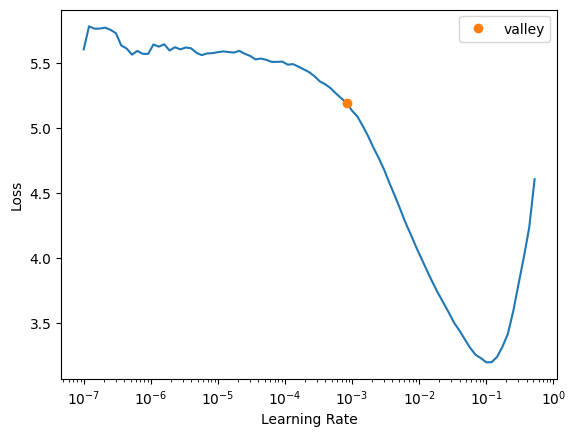

In [31]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_suggestion = learn.lr_find()
print(f"Suggested learning rate: {lr_suggestion}")
# learn.recorder.plot_lr_find()

In [34]:
lr_suggestion.valley

0.0008317637839354575

In [36]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3, base_lr=lr_suggestion.valley)

epoch,train_loss,valid_loss,error_rate,time
0,2.181071,0.442025,0.138701,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.639713,0.273206,0.092016,00:43
1,0.424095,0.226848,0.073072,00:46
2,0.314515,0.212428,0.068336,00:45


### Transfer Learning & Unfreezing
Wir trainieren nicht das komplette Modell. Wir verwenden sein Vorwissen und passen nur das letzte Stück seines „Gehirns“ an unsere neue Aufgabe an.

In [37]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.159785,0.373585,0.119756,00:31
1,0.547727,0.267181,0.092016,00:29
2,0.309929,0.242540,0.079838,00:31


In [38]:
learn.unfreeze()

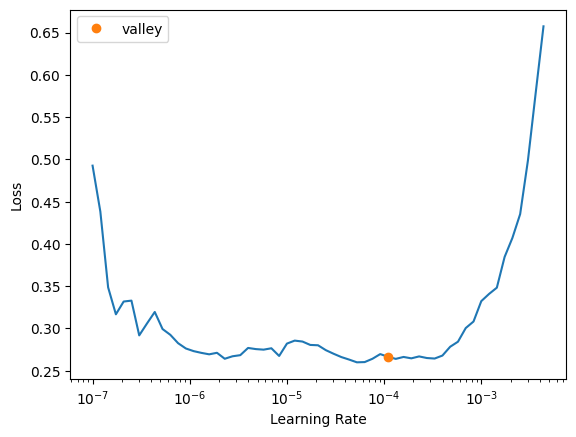

In [39]:
lr_suggestion_transfer = learn.lr_find()

In [40]:
learn.fit_one_cycle(6, lr_max=lr_suggestion_transfer.valley)


epoch,train_loss,valid_loss,error_rate,time
0,0.278642,0.269253,0.086604,00:40
1,0.347921,0.341803,0.110961,00:42
2,0.272530,0.305306,0.091340,00:45
3,0.182346,0.227709,0.067659,00:46
4,0.119705,0.197515,0.062923,00:46
5,0.099673,0.196893,0.062246,00:47


### Discriminative Learning Rates

Frühe Schichten im Modell erkennen einfache Dinge wie Kanten, Linien, Helligkeit
*  Die sind immer nützlich → brauchen kleine Lernrate

Spätere Schichten erkennen komplexere Dinge wie Augen, Sonnenuntergänge, Hundeschnauzen
*  Diese sollten sich stärker anpassen → brauchen größere Lernrate

In [41]:
# Erste Schicht trainiert ganz langsam

# Letzte Schicht trainiert viel schneller

# Alle anderen in der Mitte bekommen passende Zwischenwerte

learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.085664,0.197584,0.061570,00:38
1,0.086975,0.196210,0.061570,00:44
2,0.082549,0.196415,0.060893,00:45
3,0.065836,0.208110,0.062923,00:45
4,0.069653,0.205825,0.065629,00:46
5,0.057346,0.207977,0.062923,00:46
6,0.050881,0.207009,0.061570,00:46
7,0.058125,0.205157,0.057510,00:46
8,0.048986,0.198146,0.060217,00:46
9,0.043907,0.193681,0.060217,00:47


### Deeper Architectures
#### Mixed Precision Training (to_fp16)
Rechne intern mit halber Genauigkeit (16-bit statt 32-bit), wenn möglich.
Schnell + braucht weniger Speicher!

In [44]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,2.195825,0.489333,0.147497,00:32
1,0.882509,0.342221,0.104871,00:32
2,0.545652,0.284834,0.087957,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.290887,0.217962,0.073072,00:41
1,0.250390,0.255175,0.075101,00:43
2,0.187429,0.251934,0.071719,00:44
3,0.137558,0.218817,0.064953,00:49
4,0.087025,0.211853,0.064276,00:46
5,0.067405,0.207002,0.059540,00:48


In [45]:
# learn.interpret.show_at(3)